In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import graphviz
from graphviz import Graph

import env
import wrangle_zillow
import os

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

In [2]:
# change display settings to show all columns
pd.set_option("display.max_columns", None)

In [3]:
# use a function to pull in, clean, split, and scale the zillow data
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_zillow.prep_zillow_data()
train.head(2)

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,landusecode,regionidcounty,regionidzip,structuretaxvalue,taxvalue,assessmentyear,landtaxvalue,taxamount,logerror,transactiondate,landusedesc,age,los_angeles,orange,ventura
23907,2.0,3,1690,orange,33872532,-117890055,11100,122,1286,97039,118231,279973,2016,161742,3303,-0.055371,2017-04-06,Single Family Residential,64,0,1,0
54621,2.0,4,1445,orange,33868950,-117806403,6300,122,1286,97026,88862,381765,2016,292903,4494,0.030305,2017-07-07,Single Family Residential,50,0,1,0


In [4]:
train.shape

(24847, 22)

In [5]:
train.columns

Index(['bathrooms', 'bedrooms', 'area', 'counties', 'latitude', 'longitude',
       'lot_area', 'landusecode', 'regionidcounty', 'regionidzip',
       'structuretaxvalue', 'taxvalue', 'assessmentyear', 'landtaxvalue',
       'taxamount', 'logerror', 'transactiondate', 'landusedesc', 'age',
       'los_angeles', 'orange', 'ventura'],
      dtype='object')

In [6]:
train.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,bathrooms,bedrooms,area,latitude,longitude,lot_area,structuretaxvalue,taxvalue,landtaxvalue,taxamount,logerror,age,los_angeles,orange,ventura
count,24847,24847,24847,24847,24847,24847,24847,24847,24847,24847,24847,24847,24847,24847,24847
mean,2.05783,2.98112,1545.19,3.3988e+07,-1.18168e+08,6660.88,131894,343912,212054,4250.82,0.00380957,52.6697,0.554715,0.343019,0.102266
std,0.673162,0.8719,526.326,275983,383374,2404.94,74383.4,196317,156761,2257.75,0.0421077,21.8841,0.497007,0.474727,0.303004
min,1,1,501,3.33395e+07,-1.19448e+08,236,44,3254,1627,49,-0.111444,4,0,0,0
25%,2,2,1158,3.37864e+07,-1.18375e+08,5616.5,75228,188462,75790.5,2511.5,-0.0208791,36,0,0,0
50%,2,3,1452,3.39552e+07,-1.18105e+08,6100,118073,327766,187917,4037,0.00426836,55,1,0,0
75%,2.5,4,1850,3.41801e+07,-1.17886e+08,7513.5,175883,472786,314106,5722.5,0.0283306,67,1,1,0
max,4,6,3236,3.47184e+07,-1.17555e+08,16020,364196,951279,686939,10680,0.123189,113,1,1,1


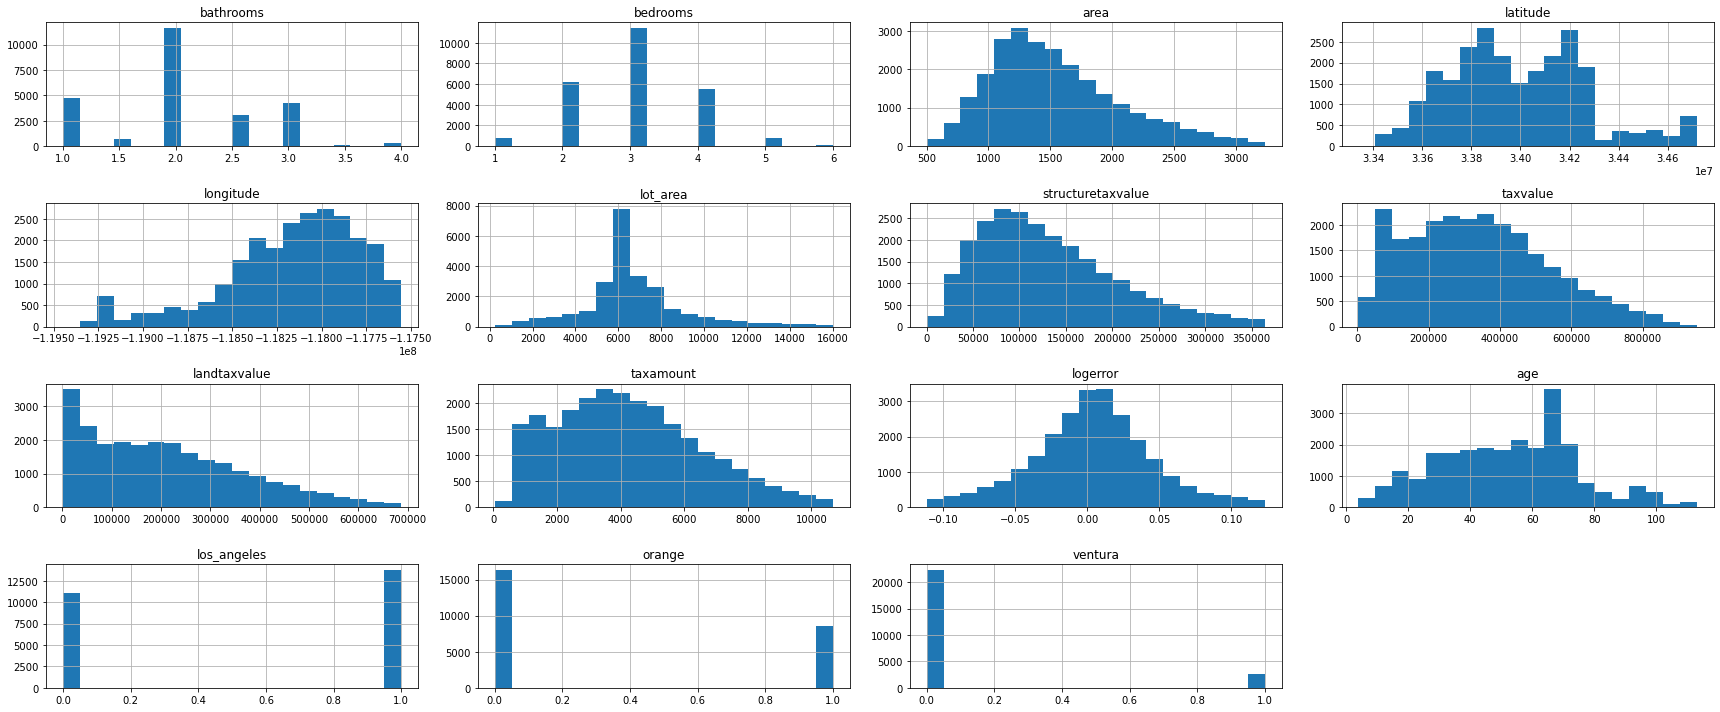

In [7]:
# check distribution of numerical columns
train.hist(figsize=(24, 10), bins=20)
plt.tight_layout()

In [8]:
train[['counties','landusedesc']].value_counts()

counties     landusedesc                               
los_angeles  Single Family Residential                     12572
orange       Single Family Residential                      5414
             Condominium                                    3109
ventura      Single Family Residential                      1686
los_angeles  Condominium                                    1207
ventura      Condominium                                     684
             Cluster Home                                    162
             Manufactured, Modular, Prefabricated Homes        9
los_angeles  Mobile Home                                       3
             Townhouse                                         1
dtype: int64

**Takeaways**

**- Logerror is normally distributed**

**- None of the features seem to have extreme outliers although many are skewed to the right**

**- Age is skewed to the left**

## 1. Does logerror differ significantly from county to county?

In [9]:
train.groupby(by='counties').logerror.mean()

counties
los_angeles    0.002521
orange         0.005380
ventura        0.005531
Name: logerror, dtype: float64

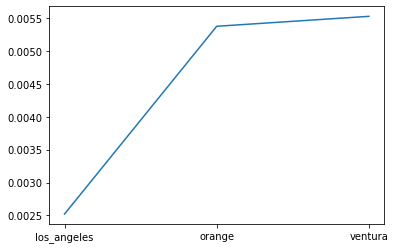

In [10]:
plt.plot(train.groupby(by='counties').logerror.mean())

In [11]:
train.counties.value_counts()

los_angeles    13783
orange          8523
ventura         2541
Name: counties, dtype: int64

### The logerror for LA County is only about half of that for the other counties and could be because it had more than 1.5 times as many transactions as Orange County and  almost 5.5 times as many transactions as Ventura County which provides more data points for a more accurate model. 

## 2. Is there a correlation between logerror and age?

<AxesSubplot:xlabel='logerror', ylabel='age'>

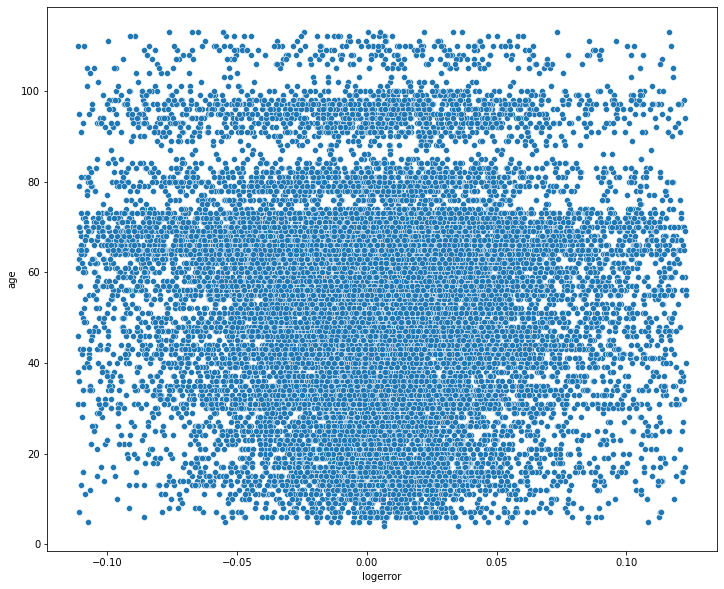

In [12]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=train, x='logerror', y='age')

### Logerror does seem to increase as age increases which tells me it's harder to predict home values with age. This is likely because quality can vary based on how well the home was cared for as well as the fact that older homes may have more unique features whereas most newer homes are built with features similar to other houses in the neighborhood.

## 3. Is there a difference in mean logerror for each of the counties? Median logerror?

In [25]:
print('Mean')
print('Orange: ',round(train[train.counties == 'orange'].logerror.mean(), 5))
print('Ventura: ',round(train[train.counties == 'ventura'].logerror.mean(), 5))
print('Los Angeles: ',round(train[train.counties == 'los_angeles'].logerror.mean(), 5))

print('Median')
print('Orange: ',round(train[train.counties == 'orange'].logerror.median(), 5))
print('Ventura: ',round(train[train.counties == 'ventura'].logerror.median(), 5))
print('Los Angeles: ',round(train[train.counties == 'los_angeles'].logerror.median(), 5))

Mean
Orange:  0.00538
Ventura:  0.00553
Los Angeles:  0.00252
Median
Orange:  0.00461
Ventura:  0.00477
Los Angeles:  0.00391


## There is a difference in mean and median logerror among the clusters. Ventura County has the highest mean and median logerror while Los Angeles has the lowest. Orange and Ventura County logerrors have less of a difference than Los Angeles to the two.

## 4. What does absolute logerror look like from county to county?

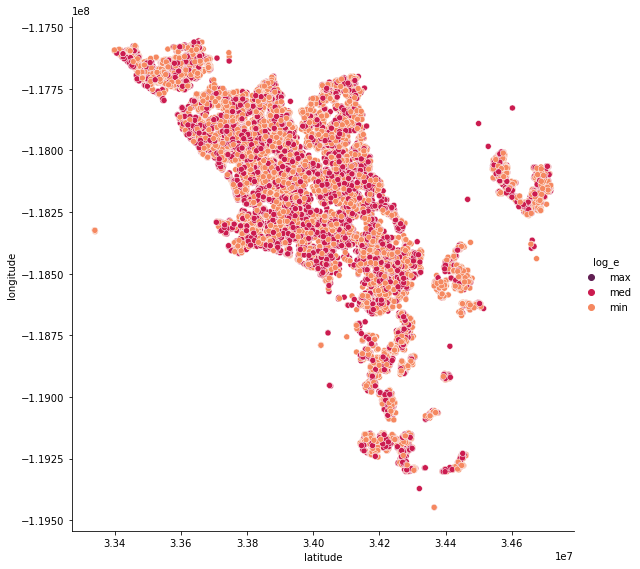

In [27]:
# add a column that bins each value of logerror into max, min, or med absolute error
train['log_e'] = pd.cut(train.logerror, bins=[-5,-1,-.03,.03,1,5], ordered=False, labels=['max','med','min','med','max'])

# plot the data to see which areas have the most logerror
sns.relplot(data=train, x='latitude', y='longitude', hue='log_e', hue_order=['max', 'med','min'], height=8, palette='rocket')

### As seen towards the center of the graph, Los Angeles County does have a higher proportion of med - max logerror which could mean the model has a harder time predicting home values from this location or could just be due to the larger number of properties sold in this area

<AxesSubplot:xlabel='counties', ylabel='proportion'>

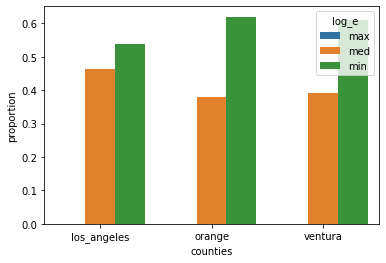

In [28]:
# plot the data to see if any county has a higher percentage of max logerrors
x, y, hue = 'counties', 'proportion', 'log_e'
hue_order = ['max', 'med', 'min']

(train[hue]
 .groupby(train[x])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

### We can barely see on the graph but it looks like the model produces a slightly higher percentage of max errors for Orange County but a higher percentage of medium error for Los Angeles County

In [13]:
train.head()

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,landusecode,regionidcounty,regionidzip,structuretaxvalue,taxvalue,assessmentyear,landtaxvalue,taxamount,logerror,transactiondate,landusedesc,age,los_angeles,orange,ventura
23907,2.0,3,1690,orange,33872532,-117890055,11100,122,1286,97039,118231,279973,2016,161742,3303,-0.055371,2017-04-06,Single Family Residential,64,0,1,0
54621,2.0,4,1445,orange,33868950,-117806403,6300,122,1286,97026,88862,381765,2016,292903,4494,0.030305,2017-07-07,Single Family Residential,50,0,1,0
61294,1.0,3,1140,los_angeles,33933129,-118233427,6442,0100,3101,96040,75128,248735,2016,173607,3322,-0.008795,2017-07-27,Single Family Residential,98,1,0,0
18931,3.0,2,1123,los_angeles,34026033,-118279728,12854,010C,3101,96221,156000,385000,2016,229000,4608,0.042080,2017-03-22,Condominium,33,1,0,0
62631,2.0,4,1649,ventura,34182508,-118930326,8021,1111,2061,96351,271840,528700,2016,256860,5657,-0.026987,2017-07-31,Single Family Residential,56,0,0,1


In [35]:
train.age.describe()

count    24847.000000
mean        52.669699
std         21.884061
min          4.000000
25%         36.000000
50%         55.000000
75%         67.000000
max        113.000000
Name: age, dtype: float64

In [46]:
train.age.dtype

dtype('int64')

In [52]:
train['age_bin'] = pd.cut(x = train.logerror, bins=[0,10,50,150])

In [53]:
train.age_bin.value_counts()

(0, 10]      13694
(10, 50]         0
(50, 150]        0
Name: age_bin, dtype: int64

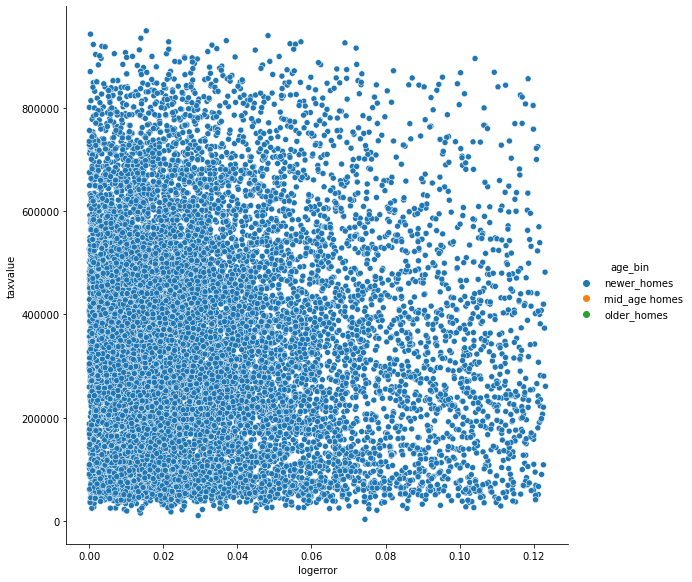

In [40]:
# plot the data to see which areas have the most logerror
sns.relplot(data=train, x='logerror', y='taxvalue', hue='age_bin', height=8)

In [31]:
train.assessmentyear.dtype

dtype('O')